скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention <br><br>

так долго возилась с causalml и graphviz, что не успела сделать доп задания:(<br>
(опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:<br>1) сделать прогноз и получить uplift для тестовой выборки <br>2) отсортировать тестовую выборку по uplift по убыванию <br>3) разбить на децили (pandas qcut вам в помощь) <br>4) для каждого дециля посчитать среднюю conversion<br><br>
(опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [31]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_curve
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

In [32]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [33]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [34]:
df.loc[(df['treatment']=='Buy One Get One') | (df['treatment']=='Discount'), 'treatment'] = 1
df.loc[df['treatment']=='No Offer', 'treatment'] = 0
df['treatment'] = df['treatment'].astype(np.int32)

сделать разбиение набора данных не тренировочную и тестовую выборки

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'], test_size = 0.3, random_state = 26)

In [36]:
X_train_full = X_train
X_train_treat = X_train['treatment']
X_train = X_train.drop(['treatment'], axis=1)
X_test_full = X_test
X_test_treat = X_test['treatment']
X_test = X_test.drop(['treatment'], axis=1)

сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

**Не придумала что тут можно сделать:(**

In [37]:
scaler = MinMaxScaler()

In [38]:
df['history']=scaler.fit_transform(df['history'].values.reshape(-1,1))

In [39]:
df['recency']=scaler.fit_transform(df['recency'].values.reshape(-1,1))

In [40]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,0.818182,0.033912,1,0,Surburban,0,Phone,1,0
1,0.454545,0.090198,1,1,Rural,1,Web,0,0
2,0.545455,0.045435,0,1,Surburban,1,Web,1,0
3,0.727273,0.194768,1,0,Rural,1,Web,1,0
4,0.090909,0.004629,1,0,Urban,0,Web,1,0


провести uplift-моделирование 3 способами: <br>одна модель с признаком коммуникации (S learner),

In [41]:
cat_features = ['zip_code','channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [42]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=26, silent=True))
sm = sm.fit(X_train, y_train, X_train_treat, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test_treat, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test_treat, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)


 модель с трансформацией таргета (трансформация классов п. 2. 1)

In [43]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=26, silent=True))
ct = ct.fit(X_train, y_train, X_train_treat, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test_treat, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test_treat, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)

 и вариант с двумя независимыми моделями

In [44]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=26, silent=True),
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=26, silent=True),
    method='vanilla')

tm = tm.fit(X_train, y_train, X_train_treat,
           estimator_trmnt_fit_params={'cat_features': cat_features},
           estimator_ctrl_fit_params={'cat_features': cat_features})

uplift_tm = tm.predict(X_test)

tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test_treat, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test_treat, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)

в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [45]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.086042,0.071816
1,ClassTransformation,0.076057,0.064292
2,TwoModels,0.072938,0.069225


*SoloModel показала лучшие характеристики, причем у неё больше всего разница между 10% и 20% (я так понимаю, она лучше отобрала более "критичных" клиентов*<br>
*Хотя по кривым uplift'а (ниже) кажется, что лучше сработала модель трансформации класса*

In [46]:
#важность признаков SoloModel
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.328206
1,treatment,19.214739
2,recency,11.935234
3,used_bogo,11.572323
4,zip_code,10.796651
5,history,9.376630
6,channel,8.512528
7,used_discount,8.263689


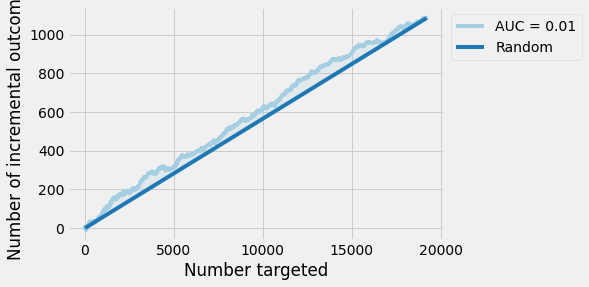

In [47]:
plot_uplift_curve(y_test, uplift_sm, X_test_treat, perfect=False);

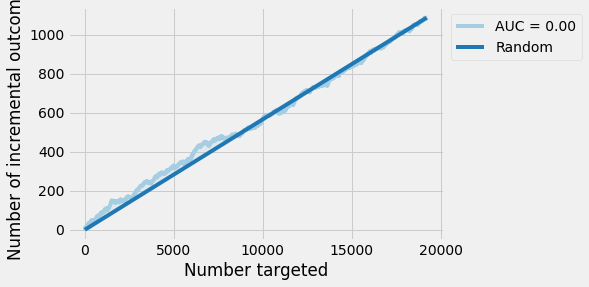

In [48]:
plot_uplift_curve(y_test, uplift_ct, X_test_treat, perfect=False);

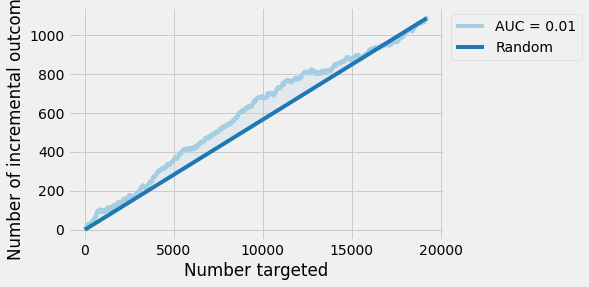

In [49]:
plot_uplift_curve(y_test, uplift_tm, X_test_treat, perfect=False);

построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [50]:
X_train_tree = pd.concat([X_train.drop('zip_code', 1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


In [51]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

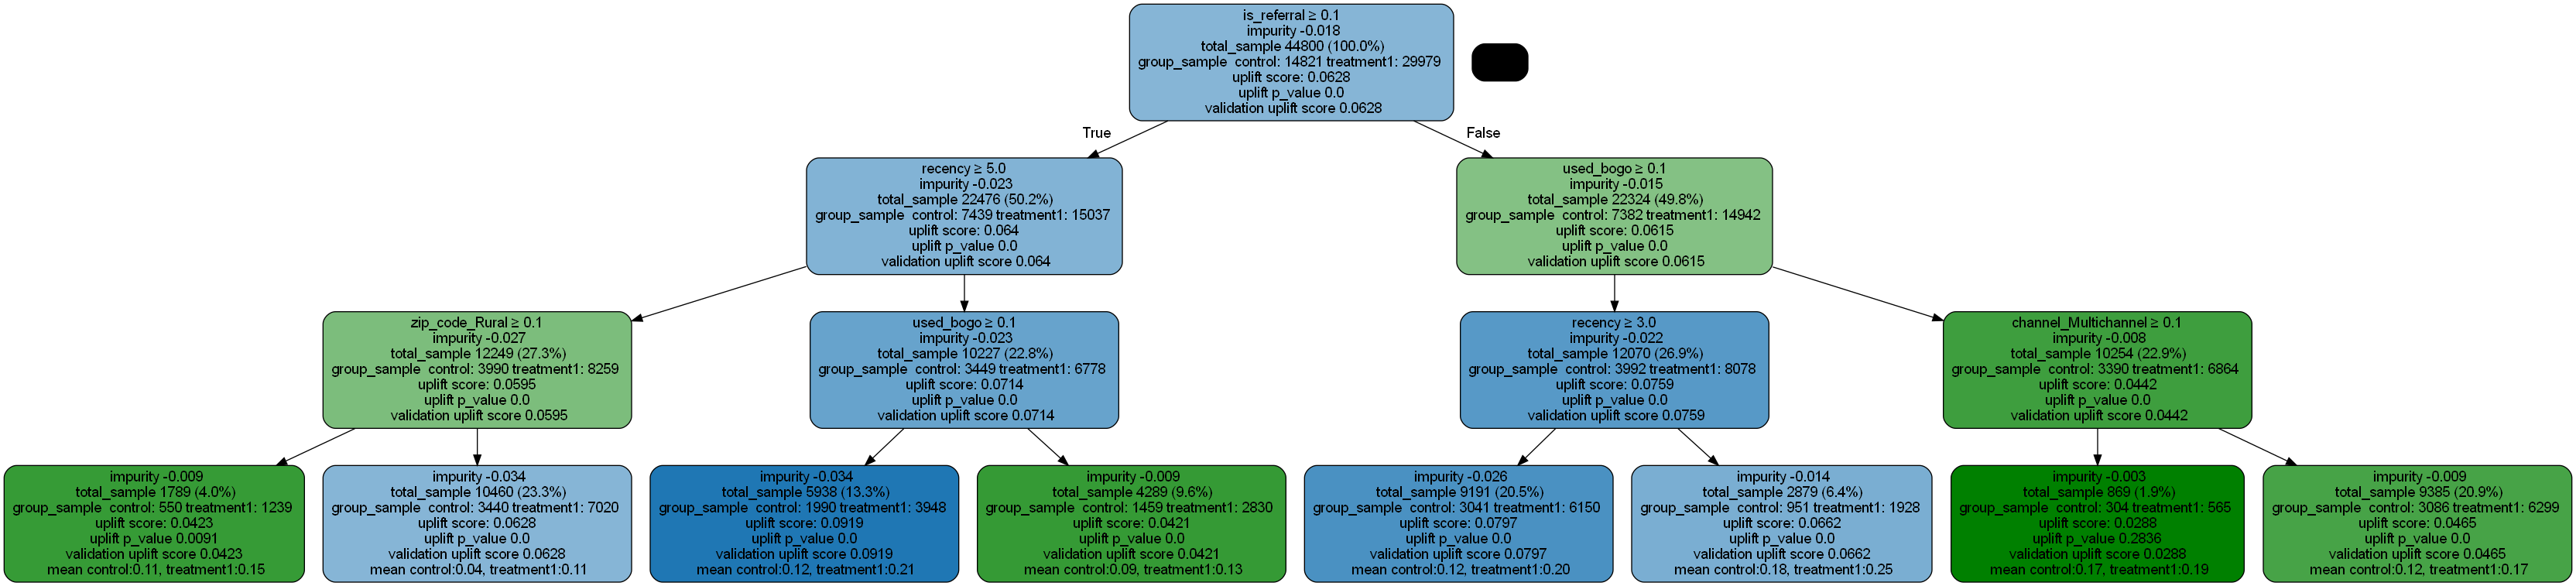

In [52]:
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control', random_state=26)

uplift_model.fit(X_train_tree.values,
                 treatment=X_train_treat.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Дерево присваивает разные значени uplift score разным категориям клиентов. Клиентов модель делит на категории, задавая вопросы касательно признаков. Видно, что самый первый вопрос касается того, реферальный ли клиент (что совпадает с высокой важностью этого признака в SoloModel). Также важными признаками являются Recency (как давноо клиент совершал покупки) и used_bogo (пользовался ли клиент акцией Buy One Get One) (оба признака упоминаются в дереве дважды) 